One the new feature added to the fitting procedure of Luci is a weighted Voronoï tessellation. We will describe here an example to showcase this method for your own data analysis.

You can download the example data using the following command:

In [ ]:
wget -O NGC1275_SN3.hdf5 https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/2473289z.hdf5

This will download the hdf5 file for SN3 (R~400) NGC 6946. The file is just under 900 Mb, so the download may take a while. Note you may need to change the name of the HDF5 file to NGC6946_SN3.merged.cm1.1.0.

The region files used in the examples can be found in the ‘Examples/regions’ folder. To run the examples, place these region files in the same directory as the hdf5 file.

First, we will import the appropriate modules:

In [24]:
# Imports
import sys
sys.path.insert(0, '/home/bvigneron/LUCI/')
from LuciBase import Luci
import matplotlib.pyplot as plt
import numpy as np
import LUCI.LuciPlotting as lplt
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib import cm
from matplotlib.colors import LogNorm

The next step is to load/read the HDF5 data cube. To do this we invoke LUCI by initiating an instance of her along with the proper parameters. First we define the correct parameters:

In [2]:
#Set Parameters
# Using Machine Learning Algorithm for Initial Guess
Luci_path = '/home/bvigneron/LUCI/'
cube_dir = '/home/bvigneron/NGC1275/Benjamin'  # Path to data cube
cube_name = 'NGC1275_SN3'  # don't add .hdf5 extension
object_name = 'NGC1275-SN3'
redshift = 0.017284  # Redshift of M33
resolution = 7000

From there we will load the HDF5 cube following this command as usual.

In [3]:
cube = Luci(Luci_path, cube_dir+'/'+cube_name, cube_dir, object_name, redshift, resolution)

Reading in data...


100%|█████████████████████████████████████████████| 9/9 [03:11<00:00, 21.32s/it]


2022-04-26 11:42:44.023487: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-26 11:42:44.027219: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (m101): /proc/driver/nvidia/version does not exist
2022-04-26 11:42:44.038198: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


And extract a background region.

In [4]:
bkg_axis, bkg_sky = cube.extract_spectrum_region(cube_dir+'/ds9 .reg/bkg.reg', mean=True)  # We use mean=True to take the mean of the emission in the region instead of the sum

100%|█████████████████████████████████████| 2064/2064 [00:00<00:00, 6353.81it/s]


Now we can call the wvt_fit_region function that will create the weighted Voronoï region and fit the bins to produce the maps we need.

In [5]:
cube.wvt_fit_region(800, 850, 800, 850,
                ['NII6548', 'Halpha', 'NII6583'], 
                'sincgauss',
                [1,1,1],
                [1,1,1],
                pixel_size = 0.0000436,
                StN_target = 30,
                roundness_crit = 0.3,
                ToL = 0.01,
                bkg=bkg_sky,
                bayes_bool=False, 
                uncertainty_bool=False, 
                mean=True, 
                n_threads=4,
                initial_values = False)

#----------------WVT Algorithm----------------#


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 39.42it/s]


#----------------Algorithm Part 1----------------#
/home/bvigneron/NGC1275/Benjamin
We have 2500 Pixels! :)
Running Nearest Neighbor Algorithm
Finished Nearest Neighbor Algorithm
Starting Bin Accretion Algorithm
We have 2500 bins.
We have 0 unassigned pixels.
Reassigning unsuccessful bins
Completed Bin Accretion Algorithm
There are a total of 203 bins!
#----------------Algorithm Part 2----------------#
Beginning WVT
We are on step 1
We are on step 2
We are on step 3
We are on step 4
We are on step 5
Completed WVT in 5 step(s)!!
There are a total of 202 bins!
#----------------Algorithm Complete--------------#
#----------------Bin Mapping--------------#
#----------------Numpy Bin Mapping--------------#


100%|█████████████████████████████████████████| 201/201 [00:18<00:00, 11.06it/s]


#----------------WVT Fitting--------------#


100%|█████████████████████████████████████████| 201/201 [03:27<00:00,  1.03s/it]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

As we can see there are many arguments in this function. Let's go through them one by one to make sure we use them correctly.

The first four arguments correspond to the position of the region we want to fit in the cube.

The fifth argument refers to the emission lines we want to fit.

'sincgauss' is the fitting function to be used.

The next two arguments describes the relational constraints between the lines. For example, if we are fitting three lines and we want the velocities of the second and third lines to be tied to one another, we would simply set vel_rel=[1,2,2]. If we wanted all the lines tied, then we would put [1,1,1]. The sigma_rel parameter functions in the exact same way except it affects the broadening (velocity dispersion) of the lines.

Next we have the pixel size which for SITELLE is a fixed value of 0.0000436.

The StN_target parameter determines the signal to noise value that will act as a threshold to create the Voronoï tessels.

roundness_crit and ToL are arguments defining the roundness criteria for the pixel accretion into bins and the convergence tolerance parameter for the SNR of the bins respectively. 

We then pass the background we want to subtract, as well as the Boolean parameters to determine whether or not to run Bayesian and uncertainty analysis.

The n_threads argument determines the number of threads used for the paralelization of the function, which accelerates the whole process.

Finally, the initial_values parameter can be used to freeze the initial parameter of velocity and broadening for the fit.

Let’s look at the flux map.

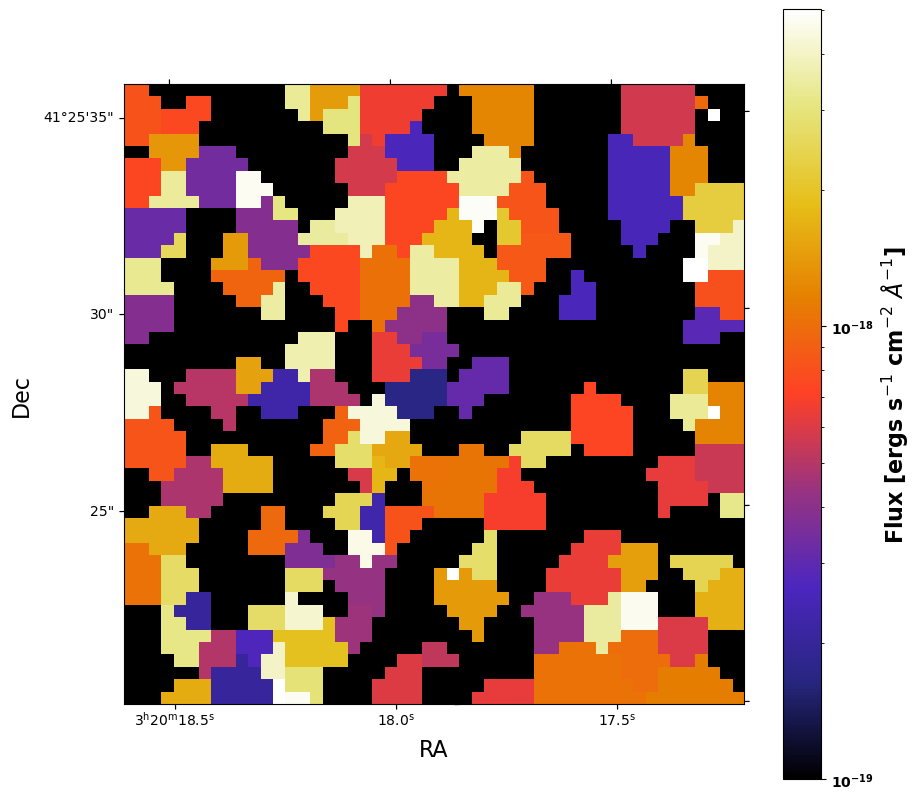

In [26]:
plt.rcdefaults()

flux_map = fits.open('/home/bvigneron/NGC1275/Benjamin/Luci_outputs/Fluxes/NGC1275-SN3_1_Halpha_Flux.fits')[0].data.T
header = fits.open('/home/bvigneron/NGC1275/Benjamin/Luci_outputs/NGC1275-HR_deep.fits')[0].header
wcs = WCS(header)
cmap = cm.CMRmap
cmap.set_bad('black',1.)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs)
plt.imshow(flux_map[800:850,800:850], norm = LogNorm(vmin=1e-19, vmax=5.01837e-18), origin='lower', cmap=cmap)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.xlabel(r'RA', fontsize=16)
plt.ylabel(r'Dec', fontsize=16)
cbar = plt.colorbar()
cbar.set_label(r'Flux [ergs s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]', fontsize=16)